In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the data
temp_data = pd.read_csv('/content/drive/MyDrive/7th sem Project/NEW PUMP2 TEMP NEW_temperature.csv')

# Drop rows with missing values
temp_data = temp_data.dropna()

# Extracting and labeling the data
pump1_temp_data = temp_data['Pump1 Temp'].values.reshape(-1, 1)
pump4_temp_data = temp_data['Pump2 Temp'].values.reshape(-1, 1)

# Labels: 0 for Pump1 (healthy), 1 for Pump4 (faulty)
pump1_temp_labels = np.zeros(len(pump1_temp_data))
pump4_temp_labels = np.ones(len(pump4_temp_data))

# Normalizing the data
scaler = MinMaxScaler(feature_range=(-1, 1))
pump1_temp_data_normalized = scaler.fit_transform(pump1_temp_data)
pump4_temp_data_normalized = scaler.fit_transform(pump4_temp_data)

# Function to create sequences
def create_sequences(data, labels, sequence_length=100):
    sequence_data = []
    sequence_labels = []
    for i in range(len(data) - sequence_length):
        sequence_data.append(data[i:i+sequence_length])
        sequence_labels.append(labels[i+sequence_length-1])
    return np.array(sequence_data), np.array(sequence_labels)

# Creating sequences for both Pump1 and Pump4
pump1_temp_sequences, pump1_temp_sequence_labels = create_sequences(pump1_temp_data_normalized, pump1_temp_labels)
pump4_temp_sequences, pump4_temp_sequence_labels = create_sequences(pump4_temp_data_normalized, pump4_temp_labels)

# Combining the sequences and labels
X_temp = np.vstack((pump1_temp_sequences, pump4_temp_sequences))
y_temp = np.hstack((pump1_temp_sequence_labels, pump4_temp_sequence_labels))

# Splitting the data into training and test sets
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Building the LSTM model for temperature data
model_temp = Sequential()

model_temp.add(LSTM(units=50, input_shape=(X_temp_train.shape[1], 1)))
model_temp.add(Dropout(0.2))

model_temp.add(Dense(units=1, activation='sigmoid'))

# Compiling the model
model_temp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history_temp = model_temp.fit(X_temp_train, y_temp_train, epochs=5, batch_size=32, validation_data=(X_temp_test, y_temp_test))



Epoch 1/5
1181/1181 [==============================] - 36s 29ms/step - loss: 0.2243 - accuracy: 0.9288 - val_loss: 0.3042 - val_accuracy: 0.8800
Epoch 2/5
1181/1181 [==============================] - 31s 27ms/step - loss: 0.2410 - accuracy: 0.9094 - val_loss: 0.1008 - val_accuracy: 0.9765
Epoch 3/5
1181/1181 [==============================] - 32s 27ms/step - loss: 0.0666 - accuracy: 0.9849 - val_loss: 0.0279 - val_accuracy: 0.9942
Epoch 4/5
1181/1181 [==============================] - 31s 27ms/step - loss: 0.1234 - accuracy: 0.9628 - val_loss: 0.0454 - val_accuracy: 0.9889
Epoch 5/5
1181/1181 [==============================] - 32s 27ms/step - loss: 0.1341 - accuracy: 0.9575 - val_loss: 0.1662 - val_accuracy: 0.9374


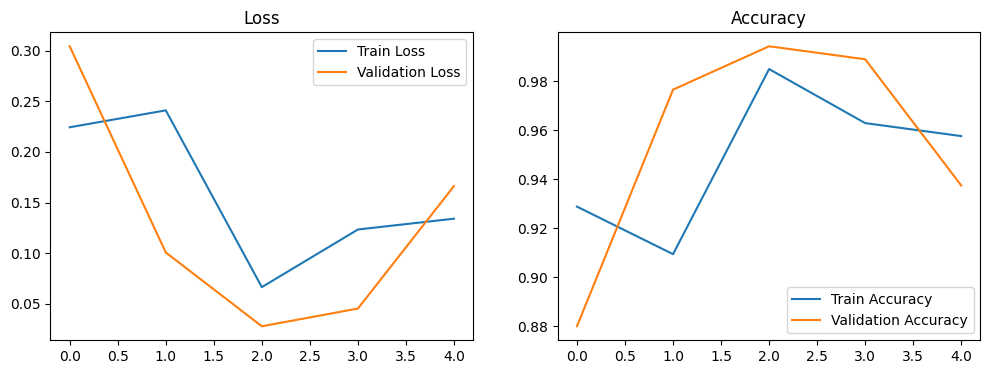

296/296 [==============================] - 3s 9ms/step


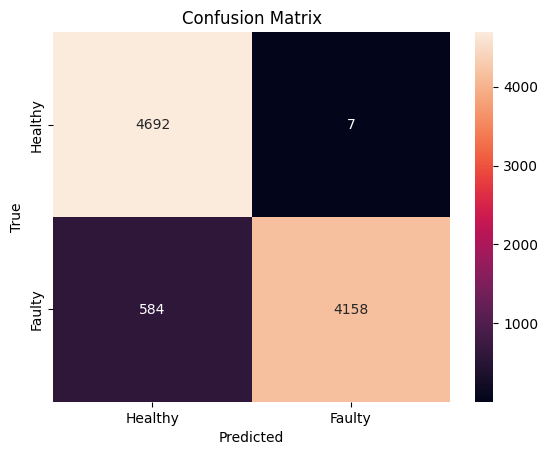

              precision    recall  f1-score   support

      Faulty       0.89      1.00      0.94      4699
     Healthy       1.00      0.88      0.93      4742

    accuracy                           0.94      9441
   macro avg       0.94      0.94      0.94      9441
weighted avg       0.94      0.94      0.94      9441



In [ ]:
# Evaluating the model (you can customize the plots and metrics as needed)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_temp.history['loss'], label='Train Loss')
plt.plot(history_temp.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_temp.history['accuracy'], label='Train Accuracy')
plt.plot(history_temp.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Predicting the test set results
y_temp_pred = model_temp.predict(X_temp_test)
y_temp_pred = (y_temp_pred > 0.5)

# Confusion Matrix
cm = confusion_matrix(y_temp_test, y_temp_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Healthy', 'Faulty'], yticklabels=['Healthy', 'Faulty'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_temp_test, y_temp_pred,target_names=['Faulty', 'Healthy']))




In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predict on the test data
y_pred = model_temp.predict(X_temp_test)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_temp_test, y_pred_binary)
precision = precision_score(y_temp_test, y_pred_binary)
recall = recall_score(y_temp_test, y_pred_binary)
f1 = f1_score(y_temp_test, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

296/296 [==============================] - 2s 8ms/step
Accuracy: 0.9374
Precision: 0.9983
Recall: 0.8768
F1 Score: 0.9336


In [ ]:
# Function to make predictions on new sequences
def predict_temp_sequence(sequence, model_temp):
    sequence = sequence.reshape((1,500, 1))
    prediction = model_temp.predict(sequence)
    return "Faulty" if prediction > 0.5 else "Healthy"

# Example usage:
sequence = temp_data['Pump2 Temp'].iloc[15000:15500].values  # You can input any sequence here
print(predict_temp_sequence(sequence, model_temp))


1/1 [==============================] - 0s 119ms/step
Healthy


In [ ]:
import numpy as np
# Preprocess and create sequences for the input data
input_data = temp_data['Pump1 Temp'].iloc[23600:23700].values  # Replace with your input data

# Normalize the input data using the same scaler
input_data = scaler.transform(np.array(input_data).reshape(-1, 1))

# Create sequences from the input data
input_sequence = []
seq_length=100
for i in range(len(input_data) - seq_length + 1):
    input_sequence.append(input_data[i:i + seq_length])
input_sequence = np.array(input_sequence)

# Reshape the input sequence
input_sequence = input_sequence.reshape((input_sequence.shape[0], input_sequence.shape[1], 1))

# Make a prediction using the model
prediction = model_temp.predict(input_sequence)

# Interpret the prediction
condition = 'Healthy' if (prediction > 0.5).any() else 'Faulty'

print(f"The pump condition is: {condition}")

1/1 [==============================] - 0s 43ms/step
The pump condition is: Healthy
